## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [4]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


#### Load cities

In [5]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)
cities = cities.drop(columns = ['capital', 'admin_name','city_ascii', 'iso3', 'id'], axis = 1)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [6]:
cities.head()

,city,lat,lng,country,iso2,population,area
0,Tokyo,35.6897,139.6922,Japan,JP,37977000.0,2194.07
1,Jakarta,-6.2146,106.8451,Indonesia,ID,34540000.0,7062.50
2,Delhi,28.6600,77.2300,India,IN,29617000.0,1484.00
3,Mumbai,18.9667,72.8333,India,IN,23355000.0,4355.00
4,Manila,14.5958,120.9772,Philippines,PH,23088000.0,1474.82


#### Load edges

In [7]:
%cd "/home/mogan/Desktop"
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

/home/mogan/Desktop


### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


In [8]:
# 0. Estimate the missing areas for cities
n_cities = cities[cities['area'].isna()]
n_cities = n_cities[n_cities['population'] > 50000]

# Can not predict for unknown population
n_cities = n_cities[~n_cities['population'].isnull()]

# Drop missing values for prediction
cities = cities[cities['population'] > 50000]
cities = cities[~cities['area'].isnull()]

In [9]:
len(n_cities)

3320

In [10]:
# 1. Construct a linear model to estimate the missing areas
X = cities['population'].values.reshape(-1, 1)
y = cities['area'].values
reg = LinearRegression().fit(X, y)

# Predict the missing areas
pred_area = reg.predict(n_cities['population'].values.reshape(-1, 1))
n_cities['area'] = pred_area

# Merge city data
cities = cities.append(n_cities)

# 2. Calculate population density again for all data
cities['density'] = cities['population'] / cities['area']

In [11]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

# Analysis for non-US checkins

### Does user live in rural or urban area?

In [12]:
cities_non_US = cities[cities['iso2']!= 'US']

# 4. Drop cities with # inhabitants < 50.000 and population density < 1500
cities_non_US = cities_non_US[(cities_non_US['population'] > 50000) & (cities_non_US['density'] > 1500)]
#cities_non_US = cities_non_US[(cities_non_US['population'] > 50000)]

cities_non_US = cities_non_US.drop_duplicates()

In [13]:
# Save cities dataframe
#cities_non_US.to_pickle("cities_non_US.pickle")

In [14]:
# Take a subset for now
B_homes[(B_homes['country'] != 'US')]
G_homes[(G_homes['country'] != 'US')]

B_homes = B_homes.sample(4000, random_state=1)
G_homes = G_homes.sample(4000, random_state=1)

In [15]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities_non_US, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities_non_US, left_on = 'country', right_on = 'iso2')

In [16]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)

In [17]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [18]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [19]:
B_homes.head()
G_homes.head()

,longitude,latitude,country,user,lives_urban
user_id,,,,,
186772,17.227778,62.410301,SE,186772,False
132303,11.984316,57.693889,SE,132303,False
88833,11.075288,49.472079,DE,88833,True
100132,4.541302,51.259372,BE,100132,False
171927,12.718308,55.902004,SE,171927,False


In [20]:
# Save intermediate results
# Save home locations
#B_merge.to_pickle("B_merge_.pickle")
#G_merge.to_pickle("G_merge_.pickle")

### Calculate # friends per user, group by rural/city and compare amount of friends


In [21]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [22]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [23]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10
38369,-0.125533,51.508415,GB,38369,True,1


#### Compare amount of friends for urban/ rural users

In [24]:
B_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,789.0,7.275032,20.260340,1.0,1.0,2.0,6.0,333.0
True,647.0,10.001546,21.431473,1.0,1.0,3.0,8.0,221.0


In [25]:
G_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,1263.0,11.070467,24.904361,1.0,2.0,5.0,10.0,475.0
True,718.0,12.742340,38.333218,1.0,2.0,4.0,10.0,658.0


/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


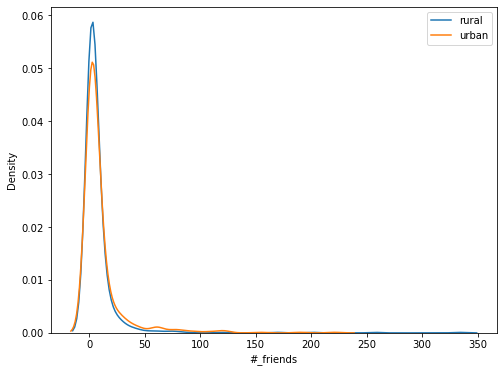

In [26]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural', hist=False)
sns.distplot(B_urban['#_friends'], label='urban', hist=False)
plt.legend();

/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


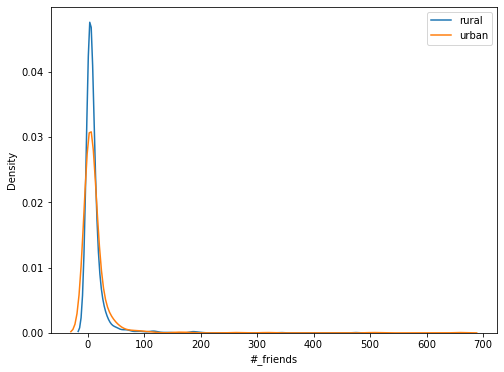

In [27]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
#sns.displot(data = G_homes, x = '#_friends', hue='lives_urban', kind="hist", bins = 30)
sns.distplot(G_rural['#_friends'], label='rural', hist=False)
sns.distplot(G_urban['#_friends'], label='urban', hist=False)
plt.legend();

#sns.displot(G_urban['#_friends'], label='urban', kind="hist")
#plt.legend();

In [69]:
homes = B_homes.append(G_homes)

In [78]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Group data together
hist_data = [homes['#_friends'][homes['lives_urban'] == True].values, 
             homes['#_friends'][homes['lives_urban'] == False].values]

group_labels = ['Urban', 'Rural']
colors = ['seagreen', 'peru']


# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=0.8)
fig.update_layout(
    title="Distribution of friends of Non-US citizens",
    xaxis_title="Number of friends",
    yaxis_title="Density",
    legend_title="User lives"
    )

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("urban_rural_friends_non_US_distribution.html", 'w') as file:
    file.write(html)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots


### Statistical Test to investigate significant effect

We will perform a poisson-test to inspect whether the two samples stem from the same possion distribution. We assume $\alpha = 0.05$.

Check assumptions:
1. Underlying distribution is a poisson
2. estimate the four rates, $\lambda_{bk-urban}, \lambda_{bk-rural},\lambda_{gw-urban},\lambda_{gw-rural}$

All four distributions seems to be a bit more skewed than expected for a poisson distribution.


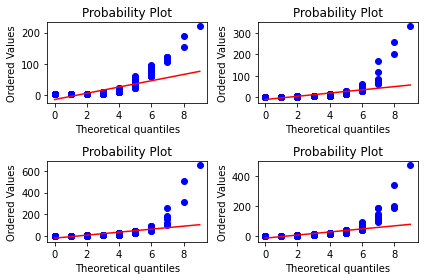

In [25]:
# 2. Inspect the distribution of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

data = B_urban['#_friends']
stats.probplot(B_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax1)
stats.probplot(B_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax2)
stats.probplot(G_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax3)
stats.probplot(G_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax4)
fig.tight_layout()

print("All four distributions seems to be a bit more skewed than expected for a poisson distribution.")

In [26]:
sample1_k, sample1_n = B_urban['#_friends'].mean(), len(B_urban)
sample2_k, sample2_n = B_rural['#_friends'].mean(), len(B_rural)
poiss_p_1 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_1,6)}.")

Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.275648.


In [27]:
sample1_k, sample1_n = G_urban['#_friends'].mean(), len(G_urban)
sample2_k, sample2_n = G_rural['#_friends'].mean(), len(G_rural)
poiss_p_2 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_2,6)}.")

Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.146261.


TODO 
Do directional hypothesis

# Analysis for US check-ins

In [171]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


In [172]:
# Take a subset for now
B_homes[(B_homes['country'] == 'US')]
G_homes[(G_homes['country'] == 'US')]

B_homes = B_homes.sample(100, random_state=1)
G_homes = G_homes.sample(100, random_state=1)

In [173]:
cities_US = cities[cities['iso2'] == 'US']

In [174]:
# We had the impression that some US cities are missing in the cities data set, so we crawled another data set from wikipedia
# Wrangle us cities to fit to other cities
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data"
us_cities = pd.read_csv("./us_cities.csv")
us_cities = us_cities.drop(columns=['2019rank', 'State[c]', '2010Census', 'Change', '2016 land area','2016 population density'])
us_cities = us_cities.rename(columns={'City':'city', '2019estimate':'population', '2016 land area.1':'area','2016 population density.1':'density' })
us_cities['population'] = us_cities['population'].str.replace(',','.')#.astype('float64')
us_cities['population'] = us_cities['population'].str.replace(r'\.', '').astype(float)
us_cities['city'] = us_cities['city'].str.replace(r'\[\w+\]', '')
us_cities['area'] = us_cities['area'].str.replace(r'\s\D+\d', '')
us_cities['area'] = us_cities['area'].str.replace(',','').astype(float)
us_cities['density'] = us_cities['density'].str.replace(r'/\D+\d', '')
us_cities['density'] = us_cities['density'].str.replace(',','').astype(float)
us_cities['Location'] = us_cities['Location'].str.split(r'/', expand = True)[1]
us_cities[['lat', 'lng']] = us_cities['Location'].str.split(r'\s', expand = True)[[1,2]]
us_cities = us_cities.drop(columns=['Location'], axis=1)
us_cities['lat'] = us_cities['lat'].str.replace('°N','').str.replace('\ufeff','').astype(float)
us_cities['lng'] = us_cities['lng'].str.replace('°W','').str.replace('\ufeff','').astype(float)
us_cities['iso2'] = 'US'
us_cities['country'] = 'United States'
us_cities['radius'] = us_cities['area'].apply(lambda x: radius(x))

us_cities.to_pickle('us_cities.pickle')
us_cities

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/data


,city,population,area,density,lat,lng,iso2,country,radius
0,New York City,8336817.0,780.9,10933.0,40.6635,73.9387,US,United States,15.766045
1,Los Angeles,3979576.0,1213.9,3276.0,34.0194,118.4108,US,United States,19.656967
2,Chicago,2693976.0,588.7,4600.0,41.8376,87.6818,US,United States,13.689011
3,Houston,2320268.0,1651.1,1395.0,29.7866,95.3909,US,United States,22.925127
4,Phoenix,1680992.0,1340.6,1200.0,33.5722,112.0901,US,United States,20.657353
...,...,...,...,...,...,...,...,...,...
312,San Angelo,101004.0,155.1,649.0,31.4411,100.4505,US,United States,7.026369
313,Vacaville,100670.0,75.1,1332.0,38.3539,121.9728,US,United States,4.889281
314,Clinton,100471.0,72.8,1380.0,42.5903,82.9170,US,United States,4.813830
315,Bend,100421.0,85.7,1171.0,44.0500,121.3000,US,United States,5.222945


In [175]:
us_cities['density'].sort_values()

68        68.0
167      236.0
122      252.0
221      264.0
90       271.0
        ...   
237     6675.0
180     6800.0
79      6891.0
15      7170.0
0      10933.0
Name: density, Length: 317, dtype: float64

In [176]:
us_cities = us_cities.append(cities_US)
us_cities = us_cities.drop_duplicates(subset=["city"], keep="last")
us_cities = us_cities[(us_cities['population'] > 50000) & (us_cities['density'] > 1500)]

cities_US = cities_US[(cities_US['population'] > 50000) & (cities_US['density'] > 1500)]

In [177]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(us_cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(us_cities, left_on = 'country', right_on = 'iso2')

#B_merge = B_homes.merge(cities_US, left_on = 'country', right_on = 'iso2')
#G_merge = G_homes.merge(cities_US, left_on = 'country', right_on = 'iso2')

In [178]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)

In [179]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [180]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [181]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [182]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

### Compare amount of friends for urban/ rural users

In [183]:
B_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,46.0,9.934783,15.459484,1.0,1.0,4.0,8.75,80.0
True,17.0,11.235294,32.757689,1.0,1.0,2.0,5.00,138.0


In [184]:
G_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,28.0,11.928571,28.494221,1.0,1.0,4.0,9.25,150.0
True,13.0,8.846154,12.628316,1.0,2.0,5.0,10.00,47.0


In [185]:
homes = B_homes.append(G_homes)

In [186]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural', hist=False)
sns.distplot(B_urban['#_friends'], label='urban', hist=False)
plt.legend();
plt.close()

/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



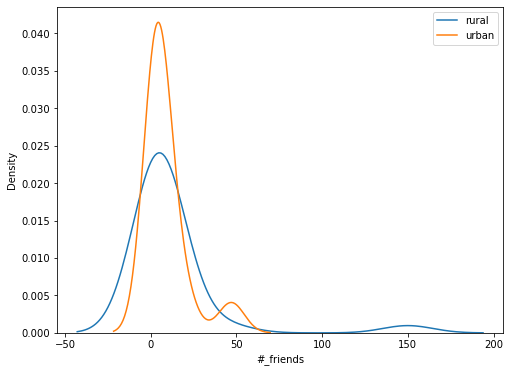

In [187]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
#sns.displot(data = G_homes, x = '#_friends', hue='lives_urban', kind="hist", bins = 30)
sns.distplot(G_rural['#_friends'], label='rural', hist=False)
sns.distplot(G_urban['#_friends'], label='urban', hist=False)
plt.legend();

#sns.displot(G_urban['#_friends'], label='urban', kind="hist")
#plt.legend();

In [188]:
homes = B_homes.append(G_homes)

In [191]:
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Group data together
hist_data = [homes['#_friends'][homes['lives_urban'] == True].values, 
             homes['#_friends'][homes['lives_urban'] == False].values]

group_labels = ['Urban', 'Rural']
colors = ['seagreen', 'peru']


# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=1, colors=colors)
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=0.8)
fig.update_layout(
    title="Distribution of friends of US citizens",
    xaxis_title="Number of friends",
    yaxis_title="Density",
    legend_title="User lives"
    )

fig.update_layout(barmode='stack')

fig.show()

%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots"

html = plot(fig, auto_open=False, output_type='div')
with open("urban_rural_friends_US_distribution.html", 'w') as file:
    file.write(html)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_/plots


### Statistical Test to investigate significant effect

We will perform a poisson-test to inspect whether the two samples stem from the same possion distribution. We assume $\alpha = 0.05$.

Check assumptions:
1. Underlying distribution is a poisson
2. estimate the four rates, $\lambda_{bk-urban}, \lambda_{bk-rural},\lambda_{gw-urban},\lambda_{gw-rural}$

All four distributions seems to be a bit more skewed than expected for a poisson distribution.


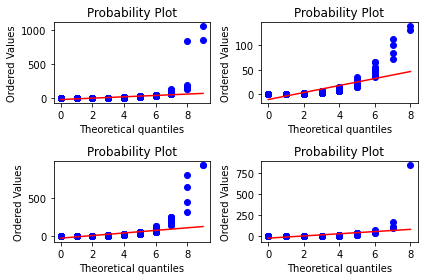

In [43]:
# 2. Inspect the distribution of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

data = B_urban['#_friends']
stats.probplot(B_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax1)
stats.probplot(B_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax2)
stats.probplot(G_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax3)
stats.probplot(G_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax4)
fig.tight_layout()

print("All four distributions seems to be a bit more skewed than expected for a poisson distribution.")

In [44]:
sample1_k, sample1_n = B_urban['#_friends'].mean(), len(B_urban)
sample2_k, sample2_n = B_rural['#_friends'].mean(), len(B_rural)
poiss_p_1 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_1,6)}.")

Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.100414.


In [45]:
sample1_k, sample1_n = G_urban['#_friends'].mean(), len(G_urban)
sample2_k, sample2_n = G_rural['#_friends'].mean(), len(G_rural)
poiss_p_2 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_2,6)}.")

Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.050589.
